## Bergfex Webscraping
<b> Milestone 3</b> 

In this part our aim is to find the nearest known snow level for our activities and to create a "snow alert" if necessary. Therefore, we use the files from Milestones 1 & 2 and compare the GPS coordinates. 
We then classify based on two conditions if a snow alert exists and add the 'snow status' to each activity.

### Installations

In [1]:
# unhash and run the below line once
#conda install -c conda-forge shapely
#conda install -c conda-forge geopy
# or 
#!pip install geopy

### Imports

In [2]:
import pandas as pd
import numpy as np

import shapely
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopy.distance

import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

# To Do

still to do:
- SD: check the creation of snow_coordinates in notebook 2
- what is SLF data?
- check if better data resolution for swiss_cities, if not add city_coordinates to data: makes the "check for yourself" useful
- add testing notebook for NB III to github? or add section to 'proof' it's working in final NB III
- the trail index has been changed to ID
- add the link to next git hub project

# 1 Importing existing files
First of all, we import the previously created files that contain all the scraped activities and the scraped snow level information.

In [5]:
# change the file_path to your path if necessary
filepath = '../data/'

# importing activity data
activities = pd.read_csv(filepath + 'activities_all_gpx.csv')

# importing snow level data merged with cities coordinates
snow = pd.read_csv(filepath + 'snow_coordinates.csv', sep=';', decimal=',')
snow = snow.dropna() ############ check?
# EPSG:4326/WGS84 ############ check?

# renaming the snow columns for later merging with the coordinates of the activity_df
snow = snow.rename(columns = {'lat':'snow_obs_lat', 'lng':'snow_obs_lng'})
snow = snow.rename(columns = {'location':'snow_obs_location', 'height_in_m':'snow_obs_alt'})
snow.head()

,snow_obs_location,snow_obs_alt,snowlevel_in_cm,snow_obs_lat,snow_obs_lng
2,Aigle,381,0,46.319025,6.970566
3,Altdorf,449,0,46.880600,8.639400
4,Andermatt,2282,0,46.602389,8.611800
5,Appenzell,780,0,47.333300,9.416700
6,Beatenberg,1182,0,46.703541,7.809551


In [6]:
snow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 2 to 76
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   snow_obs_location  48 non-null     object 
 1   snow_obs_alt       48 non-null     int64  
 2   snowlevel_in_cm    48 non-null     int64  
 3   snow_obs_lat       48 non-null     float64
 4   snow_obs_lng       48 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ KB


In [22]:
activities.shape, activities.head()

((542, 18),
        ID                                        title  difficulty    sport  \
 0  129549                                  Bornkänzeli  2 - medium   Hiking   
 1  120900  Habsburger Weg 4. Etappe: Baden - Mellingen  2 - medium   Hiking   
 2  129607                                     Aarelauf  2 - medium   Hiking   
 3  280170                          Veloroute Limmattal  2 - medium  Cycling   
 4  129555                              Mättenwilerkehr    1 - easy   Hiking   
 
    length   time  climb  min    max  technique  fitness  region  trail_id  \
 0   10.30  03:00    318  392  665.0          2        3  aargau    129549   
 1    8.41  02:14    107  349  489.0          1        3  aargau    120900   
 2   11.34  02:30     75  391  428.0          2        3  aargau    129607   
 3   46.27  03:22    327  348  554.0          2        4  aargau    280170   
 4    9.27  02:15    182  427  544.0          1        2  aargau    129555   
 
                                    

# 2 Compare hike location and snow level location
Now, we want to calculate the closest point in that df to another gps point

In [8]:
# 1st step: making Points out of the snow location #### correct?
# 2nd step: making a single multipoint object (grid) out of all the snow_points 

snow_point_list= [] # list that contains all the snow points in Point object format

# Iterating through all snow locations and creating a point made of lat & lon
for index, row in snow.iterrows():
    point = Point(row['snow_obs_lat'], row['snow_obs_lng'])
    snow_point_list.append(point)
    
len(snow_point_list) # 48 locations #### update # of loc?

# Creating a MultiPoint / Grid
snow_grid = MultiPoint(snow_point_list)

In [16]:
len(snow_point_list), snow_point_list[:5]

(48,
  <shapely.geometry.point.Point at 0x7fc8691cda30>])

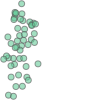

In [14]:
snow_grid

In [9]:
nearest_list = [] # list that contains tuples of nearest snow points in Point object format
near_lng = []  # contains the longitudes of the nearest snow point extracted from nearest shapely calculation
near_lat = []  # contains the latitudes of nearest snow point

# Finding which snow point is nearest to the test point 
for index, row in activities.iterrows():
    tested_point = Point(row['lat'], row['lon']) # iterates through each row of 'activities'####????
    nearest = nearest_points(tested_point, snow_grid) # records the nearest match
    nearest_list.append(nearest[1]) # the second item in the tuple is the nearest point

# Saving longitude & latitude of the nearest snow point in lists 
for i in range(len(nearest_list)):
    near_lng.append(nearest_list[i].y) 
    near_lat.append(nearest_list[i].x)

In [13]:
len(nearest_list), nearest_list[:5]

(542,
  <shapely.geometry.point.Point at 0x7fc86918d310>])

In [24]:
nearest_list[0].y, nearest_list[0].x

(7.570987799999999, 47.5378697)

In [18]:
# Test: dataframe output works for each row of trails
# should not return an error
assert len(near_lng) == len(activities)

Now we need to match those calculated nearest coordinates
with the name of the snow_point with same coordinate. 
We merge the two dataframes on coordinates, with replicating 
the rows of snow points if necessary.

In [19]:
# Adding the coordinates of the nearest snow point to each 'activity'
activities['snow_obs_lat'] = near_lat
activities['snow_obs_lng'] = near_lng

# Merged 'snow' with 'activity' (expected len is length of 'activity')
merged = pd.merge(activities, snow, on=['snow_obs_lat','snow_obs_lng'])
merged

,ID,title,difficulty,sport,length,time,climb,min,max,technique,...,region,trail_id,name,lat,lon,snow_obs_lat,snow_obs_lng,snow_obs_location,snow_obs_alt,snowlevel_in_cm
0,129549,Bornkänzeli,2 - medium,Hiking,10.30,03:00,318,392,665.0,2,...,aargau,129549,Bornkänzeli,47.320610,7.907470,47.537870,7.570988,Binningen,316,0
1,129607,Aarelauf,2 - medium,Hiking,11.34,02:30,75,391,428.0,2,...,aargau,129607,Aarelauf,47.320610,7.907470,47.537870,7.570988,Binningen,316,0
2,961881,Hüslischnegg am Asperstrihen,2 - medium,Hiking,5.00,01:23,173,670,804.0,3,...,aargau,961881,Hüslischnegg am Asperstrihen,47.436832,8.029861,47.537870,7.570988,Binningen,316,0
3,129624,Rundwanderung Engelberg,2 - medium,Hiking,11.17,03:30,283,395,702.0,1,...,aargau,129624,Rundwanderung Engelberg,47.320080,7.899660,47.537870,7.570988,Binningen,316,0
4,897134,PanoramatourAG-Strihen-ZeiherHomberg,1 - easy,Mountainbike,25.29,01:31,756,438,740.0,1,...,aargau,897134,PanoramatourAG-Strihen-ZeiherHomberg,47.462158,7.996060,47.537870,7.570988,Binningen,316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,707118,Rundwanderung von der Fiescheralp durch den Tä...,2 - medium,Hiking,10.52,03:05,312,2177,2357.0,4,...,wallis,707118,Rundwanderung von der Fiescheralp durch den Tä...,46.413502,8.103486,46.506592,8.304801,Ulrichen,1345,0
538,819423,Vom Mattmark-Stausee zur goldenen Madonna auf ...,2 - medium,Hiking,14.60,05:00,642,2199,2841.0,3,...,wallis,819423,Vom Mattmark-Stausee zur goldenen Madonna auf ...,46.047859,7.954258,46.109107,7.929712,Saas Fee,1790,0
539,130874,Maultierweg / Alter Saumweg Saas-Fee,1 - easy,Thematic route,1.52,00:45,260,1560,1820.0,1,...,wallis,130874,Maultierweg / Alter Saumweg Saas-Fee,46.123535,7.936877,46.109107,7.929712,Saas Fee,1790,0
540,50737,Via ferrata Mammut - Route C,2 - medium,Via ferrata,5.53,03:30,791,1603,2164.0,0,...,wallis,50737,Klettersteig Schweifinen - Route C,46.023659,7.748089,45.983056,7.782200,Zermatt,1638,0


# 3 Calculate the snow alert

## Condition 1: Relevance of snow level
We want to make sure our snow level is actually relevant: 
The snow point has to be less than 30 km away from the hike (30 km is in between the average resolution of the snow thickness maps of SLF, the hi res being 2-5 km, the larger one around 50).

In [26]:
# Calculating the distance between gps point and nearest point
distance = []  # contains the distances in km from snow measurement to hike start
for index, row in merged.iterrows(): # iterating through merged df
    gps_coords = (row['lat'], row['lon'])
    snow_coords = (row['snow_obs_lat'], row['snow_obs_lng'])
    d = round(geopy.distance.geodesic(gps_coords, snow_coords).km, 1)
    distance.append(d)

# Append distance to df and assign status
merged['distance'] = distance
merged['snow_status'] = 'check for yourself' # starting with a default status
merged.loc[merged['distance'] > 30, 'snow_status'] = 'No local data'
merged['snow_status'].unique() #for now only 'No local data', 'check for yourself'

array(['No local data', 'check for yourself'], dtype=object)

## Condition 2: Difference in Altitude
 i.e. altitude difference should be <1000m. 
- we chose 1000 m because it's the resolution of SLF data
- #1: if the snow measurement was done more than 1000 m lower than the max alt of the hike, we want a warning saying potential snow
- #2: if the measurement is more than 1000 m higher than the max alt, we want a message saying the hike is low altitude
- #3: if any snow point in a radius of 80 km of a lower altitude has snow, we want a snow warning
- #4: if the measurement is within 1000 m up and down of the highest point, we consider it accurate

In [31]:
# 'Snow' if max alt of the hike within 1000m vertical radius of snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] > 0) & (
    merged['max'] + 1000 > merged['snow_obs_alt']), 'snow_status'] = 'Snow'

# 'No snow' if there is no snow and the max alt is <1000m over the snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] <= merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No Snow'

# 'No local data' if there is no snow and the max hike alt is >1000m over the snow point
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] > merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No local data'

# if any snow point in a radius of 60 km of a lower altitude has snow, we want a snow warning
# if the measurement is within 1000 m up and down of the highest point, we consider it accurate
merged['snow_status'].unique(), merged

(array(['No Snow', 'No local data', 'Snow'], dtype=object),
          ID                                              title     difficulty  \
 0    129549                                        Bornkänzeli     2 - medium   
 1    129607                                           Aarelauf     2 - medium   
 2    961881                       Hüslischnegg am Asperstrihen     2 - medium   
 3    129624                            Rundwanderung Engelberg     2 - medium   
 4    897134               PanoramatourAG-Strihen-ZeiherHomberg       1 - easy   
 ..      ...                                                ...            ...   
 537  707118  Rundwanderung von der Fiescheralp durch den Tä...     2 - medium   
 538  819423  Vom Mattmark-Stausee zur goldenen Madonna auf ...     2 - medium   
 539  130874               Maultierweg / Alter Saumweg Saas-Fee       1 - easy   
 540   50737                       Via ferrata Mammut - Route C     2 - medium   
 541   61913                          

## Write CSV

In [32]:
merged.to_csv(filepath + 'activities_snow_alert.csv', index = False)

This is the end of this project.
Please do check out our next project where we create a dashboard in Tableau to visualize the hikes.
## LINK